### Imports

In [1]:
using Distributions
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!
using Base.Iterators: repeated, partition
using LinearAlgebra: norm
using CounterfactualExplanations
using Distances
using BSON

include("../utils/train.jl")
include("../utils/plot.jl")
include("../utils/evaluate.jl")

evaluate_model (generic function with 1 method)

### Adversarial attack algorithms: FGSM and PGD-attack

In [2]:
function FGSM(model, loss, x, y; ϵ = 0.3, clamp_range = (0, 1))
    grads = gradient(x -> loss(model(x), y), x)[1]
    x_adv = clamp.(x + (Float32(ϵ) * sign.(grads)), clamp_range...)
    return x_adv
end

function PGD(model, loss, x, y; ϵ = 0.3, step_size = 0.01, iterations = 40, clamp_range = (0, 1))
    x_adv = clamp.(x + (randn(Float32, size(x)...) * Float32(step_size)), clamp_range...); # start from the random point
    δ = Distances.chebyshev(x, x_adv)
    iteration = 1; while (δ < ϵ) && iteration <= iterations
        x_adv = FGSM(model, loss, x_adv, y; ϵ = step_size, clamp_range = clamp_range)
        δ = chebyshev(x, x_adv)
        iteration += 1
    end
    return x_adv
end

PGD (generic function with 1 method)

### Loading our MNIST data

In [3]:
x_train, y_train = TaijaData.load_mnist()
x_test, y_test = TaijaData.load_mnist_test()

x_train = (x_train .+ 1) ./ 2
x_test = (x_test .+ 1) ./ 2

784×10000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Defining model architecture

In [187]:
model = Chain(
    Dense(784, 128, relu; init=Flux.glorot_normal),
    Dense(128,  10; init=Flux.glorot_normal)
)

adv_pgd_strong = deepcopy(model)
adv_pgd_medium = deepcopy(model)
adv_pgd_weak = deepcopy(model)

spare = deepcopy(model)

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 397.789 KiB.

### Params for training and attacks

In [188]:
loss(x, y) = logitcrossentropy(x, y) # Not defining softmax in the model to help with CE
batch_size = 32
epochs = 20
clamp_range = (0, 1)
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

### Training our models

##### Clean model (no adversarial training)

In [189]:
include("../utils/train.jl")

vanilla_losses = vanilla_train(model, loss, opt, x_train, y_train, epochs, batch_size, 0, 9)

Epoch: 1
Average loss: 0.2664747898076971
Epoch: 2

Progress:  10%|█████                                    |  ETA: 0:00:54


Average loss: 0.11247080943832795
Epoch: 3


Progress:  15%|███████                                  |  ETA: 0:00:51

Average loss: 0.07677857563719154
Epoch: 4


Progress:  20%|█████████                                |  ETA: 0:00:48

Average loss: 0.057400221182468035
Epoch: 5

Progress:  25%|███████████                              |  ETA: 0:00:45


Average loss: 0.045064044724684206
Epoch: 6


Progress:  30%|█████████████                            |  ETA: 0:00:42

Average loss: 0.03461133318341648
Epoch: 7

Progress:  35%|███████████████                          |  ETA: 0:00:38


Average loss: 0.027293429097998888
Epoch: 8


Progress:  40%|█████████████████                        |  ETA: 0:00:35

Average loss: 0.02283325185441645
Epoch: 9


Progress:  45%|███████████████████                      |  ETA: 0:00:32

Average loss: 0.019551225218048786
Epoch: 10


Progress:  50%|█████████████████████                    |  ETA: 0:00:29

Average loss: 0.01613447680302197
Epoch: 11

Progress:  55%|███████████████████████                  |  ETA: 0:00:27


Average loss: 0.012646460618580265
Epoch: 12


Progress:  60%|█████████████████████████                |  ETA: 0:00:24

Average loss: 0.010981153934590596
Epoch: 13


Progress:  65%|███████████████████████████              |  ETA: 0:00:21

Average loss: 0.010183206647225598
Epoch: 14

Progress:  70%|█████████████████████████████            |  ETA: 0:00:18


Average loss: 0.009970972071788856
Epoch: 15


Progress:  75%|███████████████████████████████          |  ETA: 0:00:15

Average loss: 0.007873268117858545
Epoch: 16

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:12


Average loss: 0.0070277909900500765
Epoch: 17


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:09

Average loss: 0.006520383232795454


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:06

Epoch: 18
Average loss: 0.005922141496197583
Epoch: 19


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

Average loss: 0.00508298921364955
Epoch: 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


Average loss: 0.005102681703035765


20-element Vector{Any}:
 0.2664747898076971
 0.11247080943832795
 0.07677857563719154
 0.057400221182468035
 0.045064044724684206
 0.03461133318341648
 0.027293429097998888
 0.02283325185441645
 0.019551225218048786
 0.01613447680302197
 0.012646460618580265
 0.010981153934590596
 0.010183206647225598
 0.009970972071788856
 0.007873268117858545
 0.0070277909900500765
 0.006520383232795454
 0.005922141496197583
 0.00508298921364955
 0.005102681703035765

##### Adversarial training: PGD with epsilon 0.3 and 40 iterations of 0.01 step size

In [190]:
include("../utils/train.jl")

adversarial_losses_strong = adversarial_train(adv_pgd_strong, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.3; attack_method=:PGD, iterations=40, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 2.8302430718739826
Epoch: 2

Progress:  10%|█████                                    |  ETA: 0:11:50


Average loss: 2.3435378896077474
Epoch: 3


Progress:  15%|███████                                  |  ETA: 0:11:07

Average loss: 2.208391620953878
Epoch: 4


Progress:  20%|█████████                                |  ETA: 0:10:25

Average loss: 2.11879963499705
Epoch: 5

Progress:  25%|███████████                              |  ETA: 0:09:41


Average loss: 2.0662906029383343
Epoch: 6

Progress:  30%|█████████████                            |  ETA: 0:09:01


Average loss: 2.0325127106348675
Epoch: 7

Progress:  35%|███████████████                          |  ETA: 0:08:21


Average loss: 2.0012281933466594
Epoch: 8


Progress:  40%|█████████████████                        |  ETA: 0:07:44

Average loss: 1.9752935245513916
Epoch: 9


Progress:  45%|███████████████████                      |  ETA: 0:07:04

Average loss: 1.9582456284840901
Epoch: 10


Progress:  50%|█████████████████████                    |  ETA: 0:06:25

Average loss: 1.936105830637614
Epoch: 11


Progress:  55%|███████████████████████                  |  ETA: 0:05:45

Average loss: 1.915768869336446
Epoch: 12


Progress:  60%|█████████████████████████                |  ETA: 0:05:08

Average loss: 1.901880867322286
Epoch: 13


Progress:  65%|███████████████████████████              |  ETA: 0:04:29

Average loss: 1.8864436416625976
Epoch: 14

Progress:  70%|█████████████████████████████            |  ETA: 0:03:51


Average loss: 1.877781204287211
Epoch: 15

Progress:  75%|███████████████████████████████          |  ETA: 0:03:12


Average loss: 1.8674923355738322
Epoch: 16

Progress:  80%|█████████████████████████████████        |  ETA: 0:02:33


Average loss: 1.8611349582036336
Epoch: 17

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:55


Average loss: 1.853138351949056
Epoch: 18

Progress:  90%|█████████████████████████████████████    |  ETA: 0:01:17


Average loss: 1.849529711405436
Epoch: 19


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:38

Average loss: 1.8464858843485514
Epoch: 20


Progress: 100%|█████████████████████████████████████████| Time: 0:12:47


Average loss: 1.8399284135182699


20-element Vector{Any}:
 2.8302430718739826
 2.3435378896077474
 2.208391620953878
 2.11879963499705
 2.0662906029383343
 2.0325127106348675
 2.0012281933466594
 1.9752935245513916
 1.9582456284840901
 1.936105830637614
 1.915768869336446
 1.901880867322286
 1.8864436416625976
 1.877781204287211
 1.8674923355738322
 1.8611349582036336
 1.853138351949056
 1.849529711405436
 1.8464858843485514
 1.8399284135182699

##### Adversarial training: PGD with epsilon 0.1 and 13 iterations of 0.01 step size

In [193]:
adversarial_losses_medium = adversarial_train(adv_pgd_medium, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.1; attack_method=:PGD, iterations=13, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 1.0305775723218917
Epoch: 2


Progress:  10%|█████                                    |  ETA: 0:04:10

Average loss: 0.5794974470456441
Epoch: 3


Progress:  15%|███████                                  |  ETA: 0:03:58

Average loss: 0.4691715145190557
Epoch: 4


Progress:  20%|█████████                                |  ETA: 0:03:45

Average loss: 0.4123083698272705
Epoch: 5


Progress:  25%|███████████                              |  ETA: 0:03:29

Average loss: 0.3773918439924717
Epoch: 6


Progress:  30%|█████████████                            |  ETA: 0:03:14

Average loss: 0.3524019051214059
Epoch: 7

Progress:  35%|███████████████                          |  ETA: 0:02:59


Average loss: 0.33148650042514005
Epoch: 8


Progress:  40%|█████████████████                        |  ETA: 0:02:44

Average loss: 0.31551023511687915
Epoch: 9


Progress:  45%|███████████████████                      |  ETA: 0:02:31

Average loss: 0.29907464048465093
Epoch: 10


Progress:  50%|█████████████████████                    |  ETA: 0:02:18

Average loss: 0.29073047401706376
Epoch: 11


Progress:  55%|███████████████████████                  |  ETA: 0:02:04

Average loss: 0.28037330766916274
Epoch: 12


Progress:  60%|█████████████████████████                |  ETA: 0:01:50

Average loss: 0.27353364822119475
Epoch: 13


Progress:  65%|███████████████████████████              |  ETA: 0:01:35

Average loss: 0.267746887708207
Epoch: 14


Progress:  70%|█████████████████████████████            |  ETA: 0:01:21

Average loss: 0.2621578505799174
Epoch: 15


Progress:  75%|███████████████████████████████          |  ETA: 0:01:08

Average loss: 0.2555314412077268
Epoch: 16


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:54

Average loss: 0.251343702677389
Epoch: 17


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:40

Average loss: 0.2475958930020531
Epoch: 18


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:27

Average loss: 0.2438068842748801
Epoch: 19


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:13

Average loss: 0.23864472569450737
Epoch: 20


Progress: 100%|█████████████████████████████████████████| Time: 0:04:26


Average loss: 0.2383509834761421


20-element Vector{Any}:
 1.0305775723218917
 0.5794974470456441
 0.4691715145190557
 0.4123083698272705
 0.3773918439924717
 0.3524019051214059
 0.33148650042514005
 0.31551023511687915
 0.29907464048465093
 0.29073047401706376
 0.28037330766916274
 0.27353364822119475
 0.267746887708207
 0.2621578505799174
 0.2555314412077268
 0.251343702677389
 0.2475958930020531
 0.2438068842748801
 0.23864472569450737
 0.2383509834761421

#### Adversarial training: PGD with epsilon 0.05 and 7 iterations of 0.01 step size

In [194]:
adversarial_losses_weak = adversarial_train(adv_pgd_weak, loss, opt, x_train, y_train, epochs, batch_size, PGD, 0, 9, 0.05; attack_method=:PGD, iterations=7, step_size=0.01, clamp_range=clamp_range)

Epoch: 1
Average loss: 0.6616013310869535
Epoch: 2


Progress:  10%|█████                                    |  ETA: 0:02:06

Average loss: 0.30470944404204686
Epoch: 3


Progress:  15%|███████                                  |  ETA: 0:02:00

Average loss: 0.2169293404345711
Epoch: 4


Progress:  20%|█████████                                |  ETA: 0:01:58

Average loss: 0.17630164924065272
Epoch: 5


Progress:  25%|███████████                              |  ETA: 0:01:54

Average loss: 0.1470994167027374
Epoch: 6


Progress:  30%|█████████████                            |  ETA: 0:01:49

Average loss: 0.12627153066582977
Epoch: 7


Progress:  35%|███████████████                          |  ETA: 0:01:41

Average loss: 0.10835899102594704
Epoch: 8

Progress:  40%|█████████████████                        |  ETA: 0:01:32


Average loss: 0.09596296190644305
Epoch: 9


Progress:  45%|███████████████████                      |  ETA: 0:01:24

Average loss: 0.08414224446446945
Epoch: 10


Progress:  50%|█████████████████████                    |  ETA: 0:01:16

Average loss: 0.07378452579360455
Epoch: 11


Progress:  55%|███████████████████████                  |  ETA: 0:01:08

Average loss: 0.06658472979029174
Epoch: 12


Progress:  60%|█████████████████████████                |  ETA: 0:01:00

Average loss: 0.0603482985429427
Epoch: 13

Progress:  65%|███████████████████████████              |  ETA: 0:00:52


Average loss: 0.055758422173916675
Epoch: 14


Progress:  70%|█████████████████████████████            |  ETA: 0:00:44

Average loss: 0.0502443035332486
Epoch: 15

Progress:  75%|███████████████████████████████          |  ETA: 0:00:37


Average loss: 0.044365901503556716
Epoch: 16


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:29

Average loss: 0.040785148941158936
Epoch: 17


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:22

Average loss: 0.039063792017727
Epoch: 18


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:15

Average loss: 0.037283637624491044


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:07

Epoch: 19
Average loss: 0.0336300030068635
Epoch: 20


Progress: 100%|█████████████████████████████████████████| Time: 0:02:24


Average loss: 0.03165700148284765


20-element Vector{Any}:
 0.6616013310869535
 0.30470944404204686
 0.2169293404345711
 0.17630164924065272
 0.1470994167027374
 0.12627153066582977
 0.10835899102594704
 0.09596296190644305
 0.08414224446446945
 0.07378452579360455
 0.06658472979029174
 0.0603482985429427
 0.055758422173916675
 0.0502443035332486
 0.044365901503556716
 0.040785148941158936
 0.039063792017727
 0.037283637624491044
 0.0336300030068635
 0.03165700148284765

### Plotting random image (adversarial example and clean)

#### Clean trained model

Digit predicted by the model for the clean image: 3
Digit predicted by the model for the 
    adversarial image: 5
True label: 3


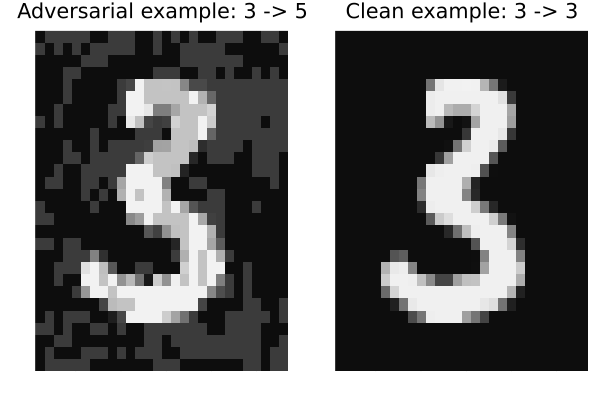

In [195]:
plot_mnist_clean_and_attack(x_train, y_train, FGSM, model, loss, 0.2; iterations=40, step_size=0.03)

#### Adversarially trained model

Digit predicted by the model for the clean image: 4
Digit predicted by the model for the 
    adversarial image: 9
True label: 4


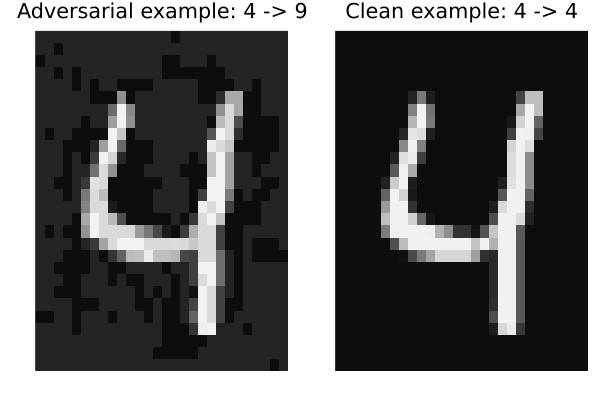

In [206]:
plot_mnist_clean_and_attack(x_test, y_test, FGSM, adv_pgd_weak, loss, 0.1; step_size=0.01, iterations=40, attack_method= :FGSM)

### Evaluating robustness - accuracy on clean and adversarial examples

#### Clean trained model

In [214]:
overview = evaluate_model(x_test, y_test, 0, 9, model, loss, FGSM, 0.2; iterations=40, attack_method=:FGSM)

overview

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 9490
  "clean_accuracy"         => 0.9812
  "adversary_changed"      => 9504
  "adversarial_accuracy"   => 0.0322

#### Strong adversary trained model

In [213]:
overview_adv = evaluate_model(x_test, y_test, 0, 9, adv_pgd_strong, loss, FGSM, 0.2; step_size=0.01, iterations=40, attack_method= :FGSM)

overview_adv

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 2551
  "clean_accuracy"         => 0.9689
  "adversary_changed"      => 2607
  "adversarial_accuracy"   => 0.7139

#### Medium adversary trained model

In [212]:
overview_adv_medium = evaluate_model(x_test, y_test, 0, 9, adv_pgd_medium, loss, FGSM, 0.2; step_size=0.01, iterations=40, attack_method= :FGSM)

overview_adv_medium

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 6057
  "clean_accuracy"         => 0.9847
  "adversary_changed"      => 6063
  "adversarial_accuracy"   => 0.379

#### Weak adversary trained model

In [211]:
overview_adv_weak = evaluate_model(x_test, y_test, 0, 9, adv_pgd_weak, loss, FGSM, 0.2; step_size=0.01, iterations=40, attack_method= :FGSM)

overview_adv_weak

Dict{Any, Any} with 4 entries:
  "adversary_forced_error" => 7357
  "clean_accuracy"         => 0.9832
  "adversary_changed"      => 7362
  "adversarial_accuracy"   => 0.2475

#### Saving the models

In [247]:
using BSON: @save, @load

@save "../models/MNIST/clean_20ep_32bs.bson" model
@save "../models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson" adv_pgd_strong
@save "../models/MNIST/adv_20ep_32bs_13it_0.01ss_0.1eps.bson" adv_pgd_medium
@save "../models/MNIST/adv_20ep_32bs_7it_0.01ss_0.05eps.bson" adv_pgd_weak
@save "../models/MNIST/spare.bson" spare

## Generating counterfactuals for normal and robust models to compare explainability

### Loading models

In [4]:
clean_model = BSON.load("../models/MNIST/clean_20ep_32bs.bson")[:model]
adv_pgd_strong = BSON.load("../models/MNIST/adv_20ep_32bs_40it_0.01ss_0.3eps.bson")[:adv_pgd_strong]
adv_pgd_medium = BSON.load("../models/MNIST/adv_20ep_32bs_13it_0.01ss_0.1eps.bson")[:adv_pgd_medium]
adv_pgd_weak = BSON.load("../models/MNIST/adv_20ep_32bs_7it_0.01ss_0.05eps.bson")[:adv_pgd_weak]

Chain(
  Dense(784 => 128, relu),              # 100_480 parameters
  Dense(128 => 10),                     # 1_290 parameters
)                   # Total: 4 arrays, 101_770 parameters, 397.789 KiB.

### Measure of implausibility

In [5]:
using Images

function convert2mnist(x)
    x = reshape(x, 28, 28) |> permutedims |> x -> Gray.(x)
    return x
end

function ssim_dist(x, y)
    x = convert2mnist(x)
    y = convert2mnist(y)
    # ssim_distance = (1 - assess(SSIM(KernelFactors.gaussian(1.5, 11), (0, 0, 1)), x, y))/2
    # return ssim_distance
    return (1 - assess_ssim(x, y)) / 2
end

function distance_from_targets_ssim(
    ce::AbstractCounterfactualExplanation;
    agg = mean,
    n_nearest_neighbors::Union{Int,Nothing} = 100,
)
    target_idx = ce.data.output_encoder.labels .== ce.target
    target_samples = ce.data.X[:, target_idx]
    x′ = CounterfactualExplanations.counterfactual(ce)
    loss = map(eachslice(x′, dims = ndims(x′))) do x
        Δ = map(eachcol(target_samples)) do xsample
            ssim_dist(x, xsample)
        end
        if n_nearest_neighbors != nothing
            Δ = sort(Δ)[1:n_nearest_neighbors]
        end
        return mean(Δ)
    end
    loss = agg(loss)[1]

    return loss
end

distance_from_targets_ssim (generic function with 1 method)

### Random counterfactuals

In [6]:
flux_clean = CounterfactualExplanations.MLP(clean_model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi) 

CounterfactualExplanations.Models.Model(Chain(Dense(784 => 128, relu), Dense(128 => 10)), :classification_multi, Chain(Dense(784 => 128, relu), Dense(128 => 10)), MLP())

CounterfactualExplanation
Convergence: ❌ after 1000 steps.
ce target: 3
SSIM distance = 0.3719477206886442
valid? 1.0
Digit predicted by the model for the clean image: 7
Digit predicted by the model for the counterfactual: 3
True label: 7


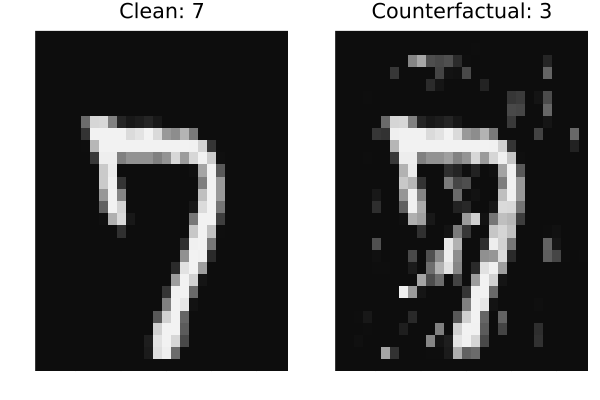

In [10]:
include("../utils/plot.jl")

using CounterfactualExplanations.Evaluation: evaluate, validity

model_to_use = flux_clean
# model_to_use = flux_adv_strong
# model_to_use = flux_adv_medium
# model_to_use = flux_adv_weak

# random point's Counterfactual
index = rand(1:10000)

different_label = rand(0:8)
if different_label >= y_test[index]
    different_label += 1
end

counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.5])
# convergence = CounterfactualExplanations.DecisionThresholdConvergence(decision_threshold=0.5, max_iter=1000)
convergence = CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.5, max_iter=1000)
 
ce = generate_counterfactual(
        reshape(x_test[:, index], 784, 1), different_label, counterfactual_data, model_to_use, generator; num_counterfactuals=1, convergence=convergence
    )

println(ce)

ces = CounterfactualExplanations.counterfactual(ce)
cfimage = ces[:, 1]

println("ce target: ", ce.target)
println("SSIM distance = ", distance_from_targets_ssim(ce))

inf_model = clean_model
# inf_model = adv_pgd_strong
# inf_model = adv_pgd_medium
# inf_model = adv_pgd_weak

cf_pred = (inf_model(cfimage) |> Flux.onecold |> getindex) - 1
println("valid? ", evaluate(ce; measure=validity)[1][1])
actualimage = x_test[:, index]
actual_pred = (inf_model(actualimage) |> Flux.onecold |> getindex) - 1
plot_normal_and_ce(actualimage, actual_pred, cfimage, cf_pred, y_test[index])

### Experimental setup

#### Setting up data splits

In [11]:
Random.seed!(42)

function generate_split(num_datapoints)
    rand(1:num_datapoints, 100)
end

function random_excluding(exclude)
    value = rand(0:8)
    return value < exclude ? value : value + 1
end

splits = [generate_split(length(y_test)) for _ in 1:5]
targets = [[random_excluding(y_test[num]) for num in split] for split in splits]

5-element Vector{Vector{Int64}}:
 [4, 5, 5, 2, 7, 0, 2, 2, 7, 5  …  2, 5, 3, 2, 4, 3, 9, 3, 9, 0]
 [9, 5, 2, 1, 6, 5, 0, 1, 6, 4  …  1, 7, 1, 7, 0, 6, 5, 3, 4, 0]
 [6, 1, 8, 7, 9, 3, 7, 3, 0, 0  …  4, 5, 6, 1, 5, 5, 5, 4, 9, 3]
 [6, 0, 9, 9, 8, 0, 4, 9, 6, 5  …  8, 4, 0, 5, 0, 4, 0, 8, 2, 0]
 [6, 4, 0, 7, 7, 4, 9, 1, 6, 8  …  6, 9, 2, 9, 3, 1, 4, 6, 7, 7]

#### Setting up Counterfactual requirements

In [12]:
flux_clean = CounterfactualExplanations.MLP(clean_model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi) 

counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.5])
convergences = []
push!(convergences, CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.5,max_iter=1000))
push!(convergences, CounterfactualExplanations.DecisionThresholdConvergence(decision_threshold=0.5, max_iter=1000))

convergences


2-element Vector{Any}:
 CounterfactualExplanations.Convergence.GeneratorConditionsConvergence(0.5, 0.01, 1000, 0.75)
 CounterfactualExplanations.Convergence.DecisionThresholdConvergence(0.5, 1000, 0.75)

### Experiment - Clean model

In [13]:
mean_implausibilities_clean_dt = []
mean_implausibilities_clean_gc = []
total_validity_dt = 0
total_validity_gc = 0
model_to_use = clean_model

@showprogress for (i, split) in enumerate(splits)
    println("here!")
    implausibilities_dt = []
    implausibilities_gc = []
    for (j, index) in enumerate(split)

        model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
        if model_pred != y_test[index]
            println("Skipping because of model misclassification")
            continue
        end

        if (j % 10 == 0)
            println("datapoint $j of split $i reached")
        end

        count = 0

        for convergence in convergences
            ce = generate_counterfactual(
            reshape(x_test'[index, :], 784, 1), targets[i][j], counterfactual_data, flux_clean, generator; num_counterfactuals=1, convergence=convergence
            )

            implausibility = distance_from_targets_ssim(ce)

            if count == 0
                total_validity_gc += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_gc, implausibility)
            elseif count == 1
                total_validity_dt += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_dt, implausibility)
            end
            
            count += 1
        end
    end
    push!(mean_implausibilities_clean_dt, mean(implausibilities_dt))
    push!(mean_implausibilities_clean_gc, mean(implausibilities_gc))
end

mean_implausibilities_clean_dt

here!
datapoint 10 of split 1 reached
datapoint 20 of split 1 reached
datapoint 30 of split 1 reached
datapoint 40 of split 1 reached
datapoint 50 of split 1 reached
datapoint 60 of split 1 reached
datapoint 70 of split 1 reached
datapoint 80 of split 1 reached
datapoint 90 of split 1 reached
datapoint 100 of split 1 reached
here!
datapoint 10 of split 2 reached
datapoint 20 of split 2 reached
datapoint 30 of split 2 reached
datapoint 40 of split 2 reached
datapoint 50 of split 2 reached
Skipping because of model misclassification
datapoint 60 of split 2 reached
datapoint 70 of split 2 reached
datapoint 80 of split 2 reached
datapoint 90 of split 2 reached
datapoint 100 of split 2 reached


Progress:  40%|█████████████████                        |  ETA: 0:32:30

here!
datapoint 10 of split 3 reached
datapoint 20 of split 3 reached
Skipping because of model misclassification
datapoint 30 of split 3 reached
datapoint 40 of split 3 reached
datapoint 50 of split 3 reached
datapoint 60 of split 3 reached
datapoint 70 of split 3 reached
Skipping because of model misclassification
datapoint 80 of split 3 reached
Skipping because of model misclassification
Skipping because of model misclassification
datapoint 90 of split 3 reached
datapoint 100 of split 3 reached

Progress:  60%|█████████████████████████                |  ETA: 0:21:27


here!
Skipping because of model misclassification
datapoint 10 of split 4 reached
datapoint 20 of split 4 reached
datapoint 30 of split 4 reached
Skipping because of model misclassification
datapoint 40 of split 4 reached
datapoint 50 of split 4 reached
Skipping because of model misclassification
datapoint 60 of split 4 reached
datapoint 70 of split 4 reached
Skipping because of model misclassification
datapoint 80 of split 4 reached
datapoint 90 of split 4 reached
Skipping because of model misclassification
datapoint 100 of split 4 reached


Progress:  80%|█████████████████████████████████        |  ETA: 0:10:44

here!
datapoint 10 of split 5 reached
datapoint 20 of split 5 reached
datapoint 30 of split 5 reached
Skipping because of model misclassification
datapoint 40 of split 5 reached
datapoint 50 of split 5 reached
datapoint 60 of split 5 reached
datapoint 70 of split 5 reached
datapoint 80 of split 5 reached
datapoint 90 of split 5 reached
datapoint 100 of split 5 reached

Progress: 100%|█████████████████████████████████████████| Time: 0:53:48


5-element Vector{Any}:
 0.43777679242422307
 0.43799570541294186
 0.43817905078058494
 0.4337871464951497
 0.43585700921889026

In [17]:
println("Using Decision Threshold Convergence:")
println("mean implausibilities using DTC: ", mean_implausibilities_clean_dt)
println("valid switches: ", total_validity_dt)
println("mean: ", mean(mean_implausibilities_clean_dt))
println("std: ", std(mean_implausibilities_clean_dt))

println("Using Generator Conditions Convergence:")
println("mean implausibilities using GCC: ", mean_implausibilities_clean_gc)
println("valid switches: ", total_validity_gc)
println("mean: ", mean(mean_implausibilities_clean_gc))
println("std: ", std(mean_implausibilities_clean_gc))

Using Decision Threshold Convergence:
mean implausibilities using DTC: Any[0.43777679242422307, 0.43799570541294186, 0.43817905078058494, 0.4337871464951497, 0.43585700921889026]
valid switches: 489.0
mean: 0.43671914086635794
std: 0.0018854338219273254
Using Generator Conditions Convergence:
mean implausibilities using GCC: Any[0.38854198524118294, 0.3956520911614494, 0.3914399930426151, 0.3845519454107425, 0.38809613711660845]
valid switches: 485.0
mean: 0.3896564303945197
std: 0.004149135868294711


### Experiment - Strong AT model

In [15]:
mean_implausibilities_strong_dt = []
mean_implausibilities_strong_gc = []
total_validity_strong_dt = 0
total_validity_strong_gc = 0
model_to_use = adv_pgd_strong

@showprogress for (i, split) in enumerate(splits)
    println("here!")
    implausibilities_dt = []
    implausibilities_gc = []
    for (j, index) in enumerate(split)

        model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
        if model_pred != y_test[index]
            println("Skipping because of model misclassification")
            continue
        end

        if (j % 10 == 0)
            println("datapoint $j of split $i reached")
        end

        count = 0

        for convergence in convergences
            ce = generate_counterfactual(
            reshape(x_test'[index, :], 784, 1), targets[i][j], counterfactual_data, flux_adv_strong, generator; num_counterfactuals=1, convergence=convergence
            )

            implausibility = distance_from_targets_ssim(ce)

            if count == 0
                total_validity_strong_gc += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_gc, implausibility)
            elseif count == 1
                total_validity_strong_dt += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_dt, implausibility)
            end
            
            count += 1
        end
    end
    push!(mean_implausibilities_strong_dt, mean(implausibilities_dt))
    push!(mean_implausibilities_strong_gc, mean(implausibilities_gc))
end

mean_implausibilities_strong_dt

here!
datapoint 10 of split 1 reached
datapoint 20 of split 1 reached
datapoint 30 of split 1 reached
datapoint 40 of split 1 reached
datapoint 50 of split 1 reached
datapoint 60 of split 1 reached
Skipping because of model misclassification
datapoint 70 of split 1 reached
datapoint 80 of split 1 reached
datapoint 90 of split 1 reached
datapoint 100 of split 1 reached
here!
datapoint 10 of split 2 reached
datapoint 20 of split 2 reached
Skipping because of model misclassification
datapoint 30 of split 2 reached
datapoint 40 of split 2 reached
Skipping because of model misclassification
Skipping because of model misclassification
datapoint 50 of split 2 reached
datapoint 60 of split 2 reached
Skipping because of model misclassification
datapoint 70 of split 2 reached
datapoint 80 of split 2 reached
datapoint 90 of split 2 reached
datapoint 100 of split 2 reached

Progress:  40%|█████████████████                        |  ETA: 0:31:17


here!
datapoint 10 of split 3 reached
datapoint 20 of split 3 reached
datapoint 30 of split 3 reached
datapoint 40 of split 3 reached
datapoint 50 of split 3 reached
datapoint 60 of split 3 reached
datapoint 70 of split 3 reached
Skipping because of model misclassification
datapoint 80 of split 3 reached
datapoint 90 of split 3 reached
datapoint 100 of split 3 reached

Progress:  60%|█████████████████████████                |  ETA: 0:20:38


here!
datapoint 10 of split 4 reached
Skipping because of model misclassification
Skipping because of model misclassification
Skipping because of model misclassification
datapoint 20 of split 4 reached
Skipping because of model misclassification
datapoint 30 of split 4 reached
datapoint 40 of split 4 reached
Skipping because of model misclassification
datapoint 50 of split 4 reached
datapoint 60 of split 4 reached
datapoint 70 of split 4 reached
datapoint 80 of split 4 reached
Skipping because of model misclassification
datapoint 90 of split 4 reached
datapoint 100 of split 4 reached


Progress:  80%|█████████████████████████████████        |  ETA: 0:10:09

here!
datapoint 10 of split 5 reached
Skipping because of model misclassification
datapoint 20 of split 5 reached
datapoint 30 of split 5 reached
Skipping because of model misclassification
datapoint 40 of split 5 reached
datapoint 50 of split 5 reached
datapoint 60 of split 5 reached
datapoint 70 of split 5 reached
datapoint 80 of split 5 reached
Skipping because of model misclassification
datapoint 90 of split 5 reached
datapoint 100 of split 5 reached


Progress: 100%|█████████████████████████████████████████| Time: 0:50:41


5-element Vector{Any}:
 0.4145930153051518
 0.4131686469842664
 0.4126407135224599
 0.41125010366840103
 0.4101581423508147

In [18]:
println("Using Decision Threshold Convergence:")
println("mean implausibilities using DTC: ", mean_implausibilities_strong_dt)
println("valid switches: ", total_validity_strong_dt)
println("mean: ", mean(mean_implausibilities_strong_dt))
println("std: ", std(mean_implausibilities_strong_dt))

println("Using Generator Conditions Convergence:")
println("mean implausibilities using GCC: ", mean_implausibilities_strong_gc)
println("valid switches: ", total_validity_strong_gc)
println("mean: ", mean(mean_implausibilities_strong_gc))
println("std: ", std(mean_implausibilities_strong_gc))

Using Decision Threshold Convergence:
mean implausibilities using DTC: Any[0.4145930153051518, 0.4131686469842664, 0.4126407135224599, 0.41125010366840103, 0.4101581423508147]
valid switches: 485.0
mean: 0.4123621243662187
std: 0.0017174903048787968
Using Generator Conditions Convergence:
mean implausibilities using GCC: Any[0.22347539670036054, 0.22505863793886008, 0.22188771905223703, 0.2131320895088706, 0.21908109626558292]
valid switches: 485.0
mean: 0.22052698789318223
std: 0.004686568057518681


### Experiment: Medium AT model

In [19]:
mean_implausibilities_medium_dt = []
mean_implausibilities_medium_gc = []
total_validity_medium_dt = 0
total_validity_medium_gc = 0
model_to_use = adv_pgd_medium

@showprogress for (i, split) in enumerate(splits)
    println("here!")
    implausibilities_dt = []
    implausibilities_gc = []
    for (j, index) in enumerate(split)

        model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
        if model_pred != y_test[index]
            println("Skipping because of model misclassification")
            continue
        end

        if (j % 10 == 0)
            println("datapoint $j of split $i reached")
        end

        count = 0

        for convergence in convergences
            ce = generate_counterfactual(
            reshape(x_test'[index, :], 784, 1), targets[i][j], counterfactual_data, flux_adv_medium, generator; num_counterfactuals=1, convergence=convergence
            )

            implausibility = distance_from_targets_ssim(ce)

            if count == 0
                total_validity_medium_gc += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_gc, implausibility)
            elseif count == 1
                total_validity_medium_dt += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_dt, implausibility)
            end
            
            count += 1
        end
    end
    push!(mean_implausibilities_medium_dt, mean(implausibilities_dt))
    push!(mean_implausibilities_medium_gc, mean(implausibilities_gc))
end

mean_implausibilities_medium_dt

here!
datapoint 10 of split 1 reached
datapoint 20 of split 1 reached
datapoint 30 of split 1 reached
datapoint 40 of split 1 reached
Skipping because of model misclassification
datapoint 50 of split 1 reached
datapoint 60 of split 1 reached
Skipping because of model misclassification
datapoint 70 of split 1 reached
datapoint 80 of split 1 reached
datapoint 90 of split 1 reached
datapoint 100 of split 1 reached
here!
datapoint 10 of split 2 reached
datapoint 20 of split 2 reached
Skipping because of model misclassification
Skipping because of model misclassification
datapoint 30 of split 2 reached
datapoint 40 of split 2 reached
Skipping because of model misclassification
datapoint 50 of split 2 reached
datapoint 60 of split 2 reached
datapoint 70 of split 2 reached
datapoint 80 of split 2 reached
datapoint 90 of split 2 reached
datapoint 100 of split 2 reached

Progress:  40%|█████████████████                        |  ETA: 0:31:36


here!
datapoint 10 of split 3 reached
datapoint 20 of split 3 reached
datapoint 30 of split 3 reached
datapoint 40 of split 3 reached
datapoint 50 of split 3 reached
datapoint 60 of split 3 reached
datapoint 70 of split 3 reached
Skipping because of model misclassification
datapoint 80 of split 3 reached
datapoint 90 of split 3 reached
datapoint 100 of split 3 reached

Progress:  60%|█████████████████████████                |  ETA: 0:20:49


here!
datapoint 10 of split 4 reached
datapoint 20 of split 4 reached
datapoint 30 of split 4 reached
datapoint 40 of split 4 reached
datapoint 50 of split 4 reached
datapoint 60 of split 4 reached
datapoint 70 of split 4 reached
datapoint 80 of split 4 reached
datapoint 90 of split 4 reached


Progress:  80%|█████████████████████████████████        |  ETA: 0:10:25

datapoint 100 of split 4 reached
here!
datapoint 10 of split 5 reached
datapoint 20 of split 5 reached
datapoint 30 of split 5 reached
Skipping because of model misclassification
datapoint 40 of split 5 reached
datapoint 50 of split 5 reached
datapoint 60 of split 5 reached
datapoint 70 of split 5 reached
datapoint 80 of split 5 reached
Skipping because of model misclassification
datapoint 90 of split 5 reached
datapoint 100 of split 5 reached


Progress: 100%|█████████████████████████████████████████| Time: 0:51:59


5-element Vector{Any}:
 0.4127359033457597
 0.4125870317500011
 0.4103797155638935
 0.407369496464206
 0.4110017455574345

In [20]:
println("Using Decision Threshold Convergence:")
println("mean implausibilities using DTC: ", mean_implausibilities_medium_dt)
println("valid switches: ", total_validity_medium_dt)
println("mean: ", mean(mean_implausibilities_medium_dt))
println("std: ", std(mean_implausibilities_medium_dt))

println("Using Generator Conditions Convergence:")
println("mean implausibilities using GCC: ", mean_implausibilities_medium_gc)
println("valid switches: ", total_validity_medium_gc)
println("mean: ", mean(mean_implausibilities_medium_gc))
println("std: ", std(mean_implausibilities_medium_gc))

Using Decision Threshold Convergence:
mean implausibilities using DTC: Any[0.4127359033457597, 0.4125870317500011, 0.4103797155638935, 0.407369496464206, 0.4110017455574345]
valid switches: 492.0
mean: 0.410814778536259
std: 0.002175190049181847
Using Generator Conditions Convergence:
mean implausibilities using GCC: Any[0.24082424456074866, 0.23973712509276368, 0.23589814734028797, 0.22722762492097157, 0.23488743054783923]
valid switches: 492.0
mean: 0.23571491449252227
std: 0.005362737642411256


### Experiment: Weak AT model

In [21]:
mean_implausibilities_weak_dt = []
mean_implausibilities_weak_gc = []
total_validity_weak_dt = 0
total_validity_weak_gc = 0
model_to_use = adv_pgd_weak

@showprogress for (i, split) in enumerate(splits)
    println("here!")
    implausibilities_dt = []
    implausibilities_gc = []
    for (j, index) in enumerate(split)

        model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
        if model_pred != y_test[index]
            println("Skipping because of model misclassification")
            continue
        end

        if (j % 10 == 0)
            println("datapoint $j of split $i reached")
        end

        count = 0

        for convergence in convergences
            ce = generate_counterfactual(
            reshape(x_test'[index, :], 784, 1), targets[i][j], counterfactual_data, flux_adv_weak, generator; num_counterfactuals=1, convergence=convergence
            )

            implausibility = distance_from_targets_ssim(ce)

            if count == 0
                total_validity_weak_gc += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_gc, implausibility)
            elseif count == 1
                total_validity_weak_dt += evaluate(ce; measure=validity)[1][1]
                push!(implausibilities_dt, implausibility)
            end
            
            count += 1
        end
    end
    push!(mean_implausibilities_weak_dt, mean(implausibilities_dt))
    push!(mean_implausibilities_weak_gc, mean(implausibilities_gc))
end

mean_implausibilities_weak_dt

here!
datapoint 10 of split 1 reached
datapoint 20 of split 1 reached
datapoint 30 of split 1 reached
datapoint 40 of split 1 reached
datapoint 50 of split 1 reached
datapoint 60 of split 1 reached
Skipping because of model misclassification
datapoint 70 of split 1 reached
datapoint 80 of split 1 reached
Skipping because of model misclassification
datapoint 90 of split 1 reached
datapoint 100 of split 1 reached
here!
datapoint 10 of split 2 reached
datapoint 20 of split 2 reached
Skipping because of model misclassification
datapoint 30 of split 2 reached
datapoint 40 of split 2 reached
datapoint 50 of split 2 reached
datapoint 60 of split 2 reached
datapoint 70 of split 2 reached
datapoint 80 of split 2 reached
datapoint 90 of split 2 reached
datapoint 100 of split 2 reached


Progress:  40%|█████████████████                        |  ETA: 0:31:05

here!
datapoint 10 of split 3 reached
datapoint 20 of split 3 reached
datapoint 30 of split 3 reached
datapoint 40 of split 3 reached
datapoint 50 of split 3 reached
datapoint 60 of split 3 reached
datapoint 70 of split 3 reached
Skipping because of model misclassification
datapoint 80 of split 3 reached
datapoint 90 of split 3 reached
datapoint 100 of split 3 reached

Progress:  60%|█████████████████████████                |  ETA: 0:20:43


here!
datapoint 10 of split 4 reached
datapoint 20 of split 4 reached
datapoint 30 of split 4 reached
datapoint 40 of split 4 reached
datapoint 50 of split 4 reached
datapoint 60 of split 4 reached
datapoint 70 of split 4 reached
datapoint 80 of split 4 reached
datapoint 90 of split 4 reached
datapoint 100 of split 4 reached


Progress:  80%|█████████████████████████████████        |  ETA: 0:10:23

here!
datapoint 10 of split 5 reached
datapoint 20 of split 5 reached
datapoint 30 of split 5 reached
Skipping because of model misclassification
datapoint 40 of split 5 reached
datapoint 50 of split 5 reached
datapoint 60 of split 5 reached
datapoint 70 of split 5 reached
datapoint 80 of split 5 reached
Skipping because of model misclassification
datapoint 90 of split 5 reached
datapoint 100 of split 5 reached


Progress: 100%|█████████████████████████████████████████| Time: 0:51:18


5-element Vector{Any}:
 0.4184785757374198
 0.4182587214701604
 0.41589372145389286
 0.41210849153153634
 0.41708944438497797

In [22]:
println("Using Decision Threshold Convergence:")
println("mean implausibilities using DTC: ", mean_implausibilities_weak_dt)
println("valid switches: ", total_validity_weak_dt)
println("mean: ", mean(mean_implausibilities_weak_dt))
println("std: ", std(mean_implausibilities_weak_dt))

println("Using Generator Conditions Convergence:")
println("mean implausibilities using GCC: ", mean_implausibilities_weak_gc)
println("valid switches: ", total_validity_weak_gc)
println("mean: ", mean(mean_implausibilities_weak_gc))
println("std: ", std(mean_implausibilities_weak_gc))

Using Decision Threshold Convergence:
mean implausibilities using DTC: Any[0.4184785757374198, 0.4182587214701604, 0.41589372145389286, 0.41210849153153634, 0.41708944438497797]
valid switches: 494.0
mean: 0.41636579091559744
std: 0.0025941360678301286
Using Generator Conditions Convergence:
mean implausibilities using GCC: Any[0.26809586590485596, 0.26555259449304847, 0.26271750891203755, 0.2523918602002133, 0.2628205541149617]
valid switches: 494.0
mean: 0.2623156767250234
std: 0.005974670038903717
